In [165]:
# before running this script, it is necessary to run fmriprep on the raw data
# https://fmriprep.org/en/stable/index.html
# example call:
#fmriprep ~/PROJECTS/fus/data/bold ~/PROJECTS/fus/data/fmriprep_out participant -w ~/PROJECTS/fus/data/fmriprep_working --fs-license-file ~/license.txt --mem 64000000000 --nprocs 10 --participant-label 02


In [166]:
import nilearn
from nilearn.image import resample_img
import nibabel as nib
from templateflow import api
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

In [167]:
subject_idx=3

In [168]:
## get functional data
path_to_data = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/func"
bold_filename = f"sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
mask_filename = "sub-03_task-prefuspost_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

In [169]:
bold = nib.load(os.path.join(path_to_data, bold_filename))
mask = nib.load(os.path.join(path_to_data, mask_filename))

In [170]:
## get atlas
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="1000Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")
atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape

# get the atlas labels
atlas_labels = np.unique(np.array(atlas.dataobj))

In [171]:
bold.shape, atlas.shape

((77, 95, 82, 900), (97, 115, 97))

In [173]:
resampled_mask = resample_img(mask, target_affine=target_affine, target_shape=target_shape[0:3], interpolation='nearest')

In [174]:
resampled_bold = resample_img(bold, target_affine=target_affine, target_shape=target_shape[0:3])

In [175]:
atlas.shape, resampled_bold.shape, resampled_mask.shape

((97, 115, 97), (97, 115, 97, 900), (97, 115, 97))

## GLM begins here

In [228]:
## design matrix generation
# column 1: baseline 0-300
stim_onsets = np.array([0,60,120,180,240])+300
stim_len = 20
isi = 60
dm = np.zeros((resampled_bold.shape[3],len(stim_onsets)+2))
# 1st column: baseline, 2nd column: stim onsets, 3rd column: stim offsets, 4th column: constant
# column 1: baseline 0-300
for i, onset in enumerate(stim_onsets):
    print(f"Onset {i}: {onset} samples")
    dm[onset:onset+stim_len,i] = 1

dm[0:300,5] = 1
dm[:,6] = 1

# create a pandas dataframe from dm
dm = pd.DataFrame(dm, columns=['stim1', 'stim2', 'stim3', 'stim4', 'stim5','baseline','constant'])

Onset 0: 300 samples
Onset 1: 360 samples
Onset 2: 420 samples
Onset 3: 480 samples
Onset 4: 540 samples


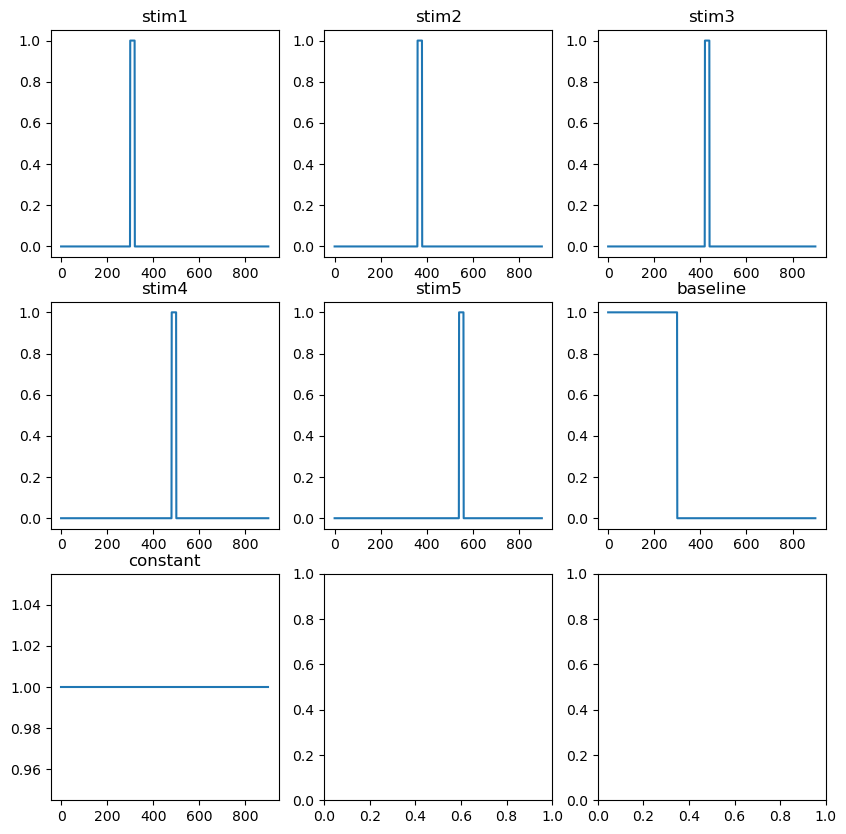

In [229]:
# plot each column of dm as a separate subplot
fig, ax = plt.subplots(3,3,figsize=(10,10))
for i in range(dm.shape[1]):
    ax.flat[i].plot(dm.iloc[:,i])
    ax.flat[i].set_title(dm.columns[i])

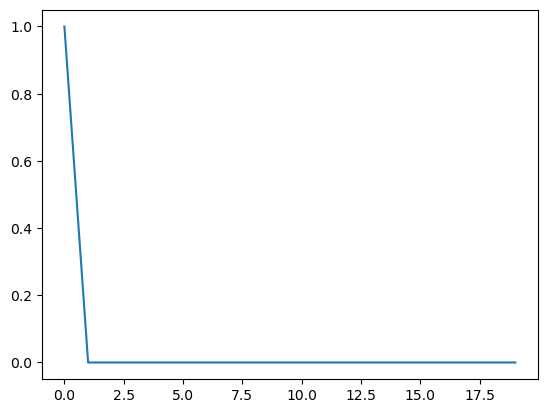

In [243]:
# create a custom hrf that models no delay at all - just a delta function
# this is a 1 sample duration event
hrf = np.zeros(20)
hrf[0] = 1
#plt.plot(hrf)

In [268]:
## set up a GLM analysis
first_level_model = FirstLevelModel(t_r=1.0, hrf_model=hrf,
                                    drift_model=None, high_pass=0.0,
                                    mask_img=resampled_mask,
                                    smoothing_fwhm=4, standardize=True)
first_level_model.fit(resampled_bold, design_matrices=[dm])

FirstLevelModel(drift_model=None, high_pass=0.0,
                hrf_model=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x413132920>,
                smoothing_fwhm=4, t_r=1.0)

In [274]:
# get the beta weights from the glm for the contrast of stimon to stimoff
beta = first_level_model.compute_contrast('stim1-baseline', output_type='z_score')

In [275]:
# plot a histogram of the beta weights
beta.get_fdata().max(), beta.get_fdata().min(), type(beta)

(8.321014896069446, -8.251253518438427, nibabel.nifti1.Nifti1Image)

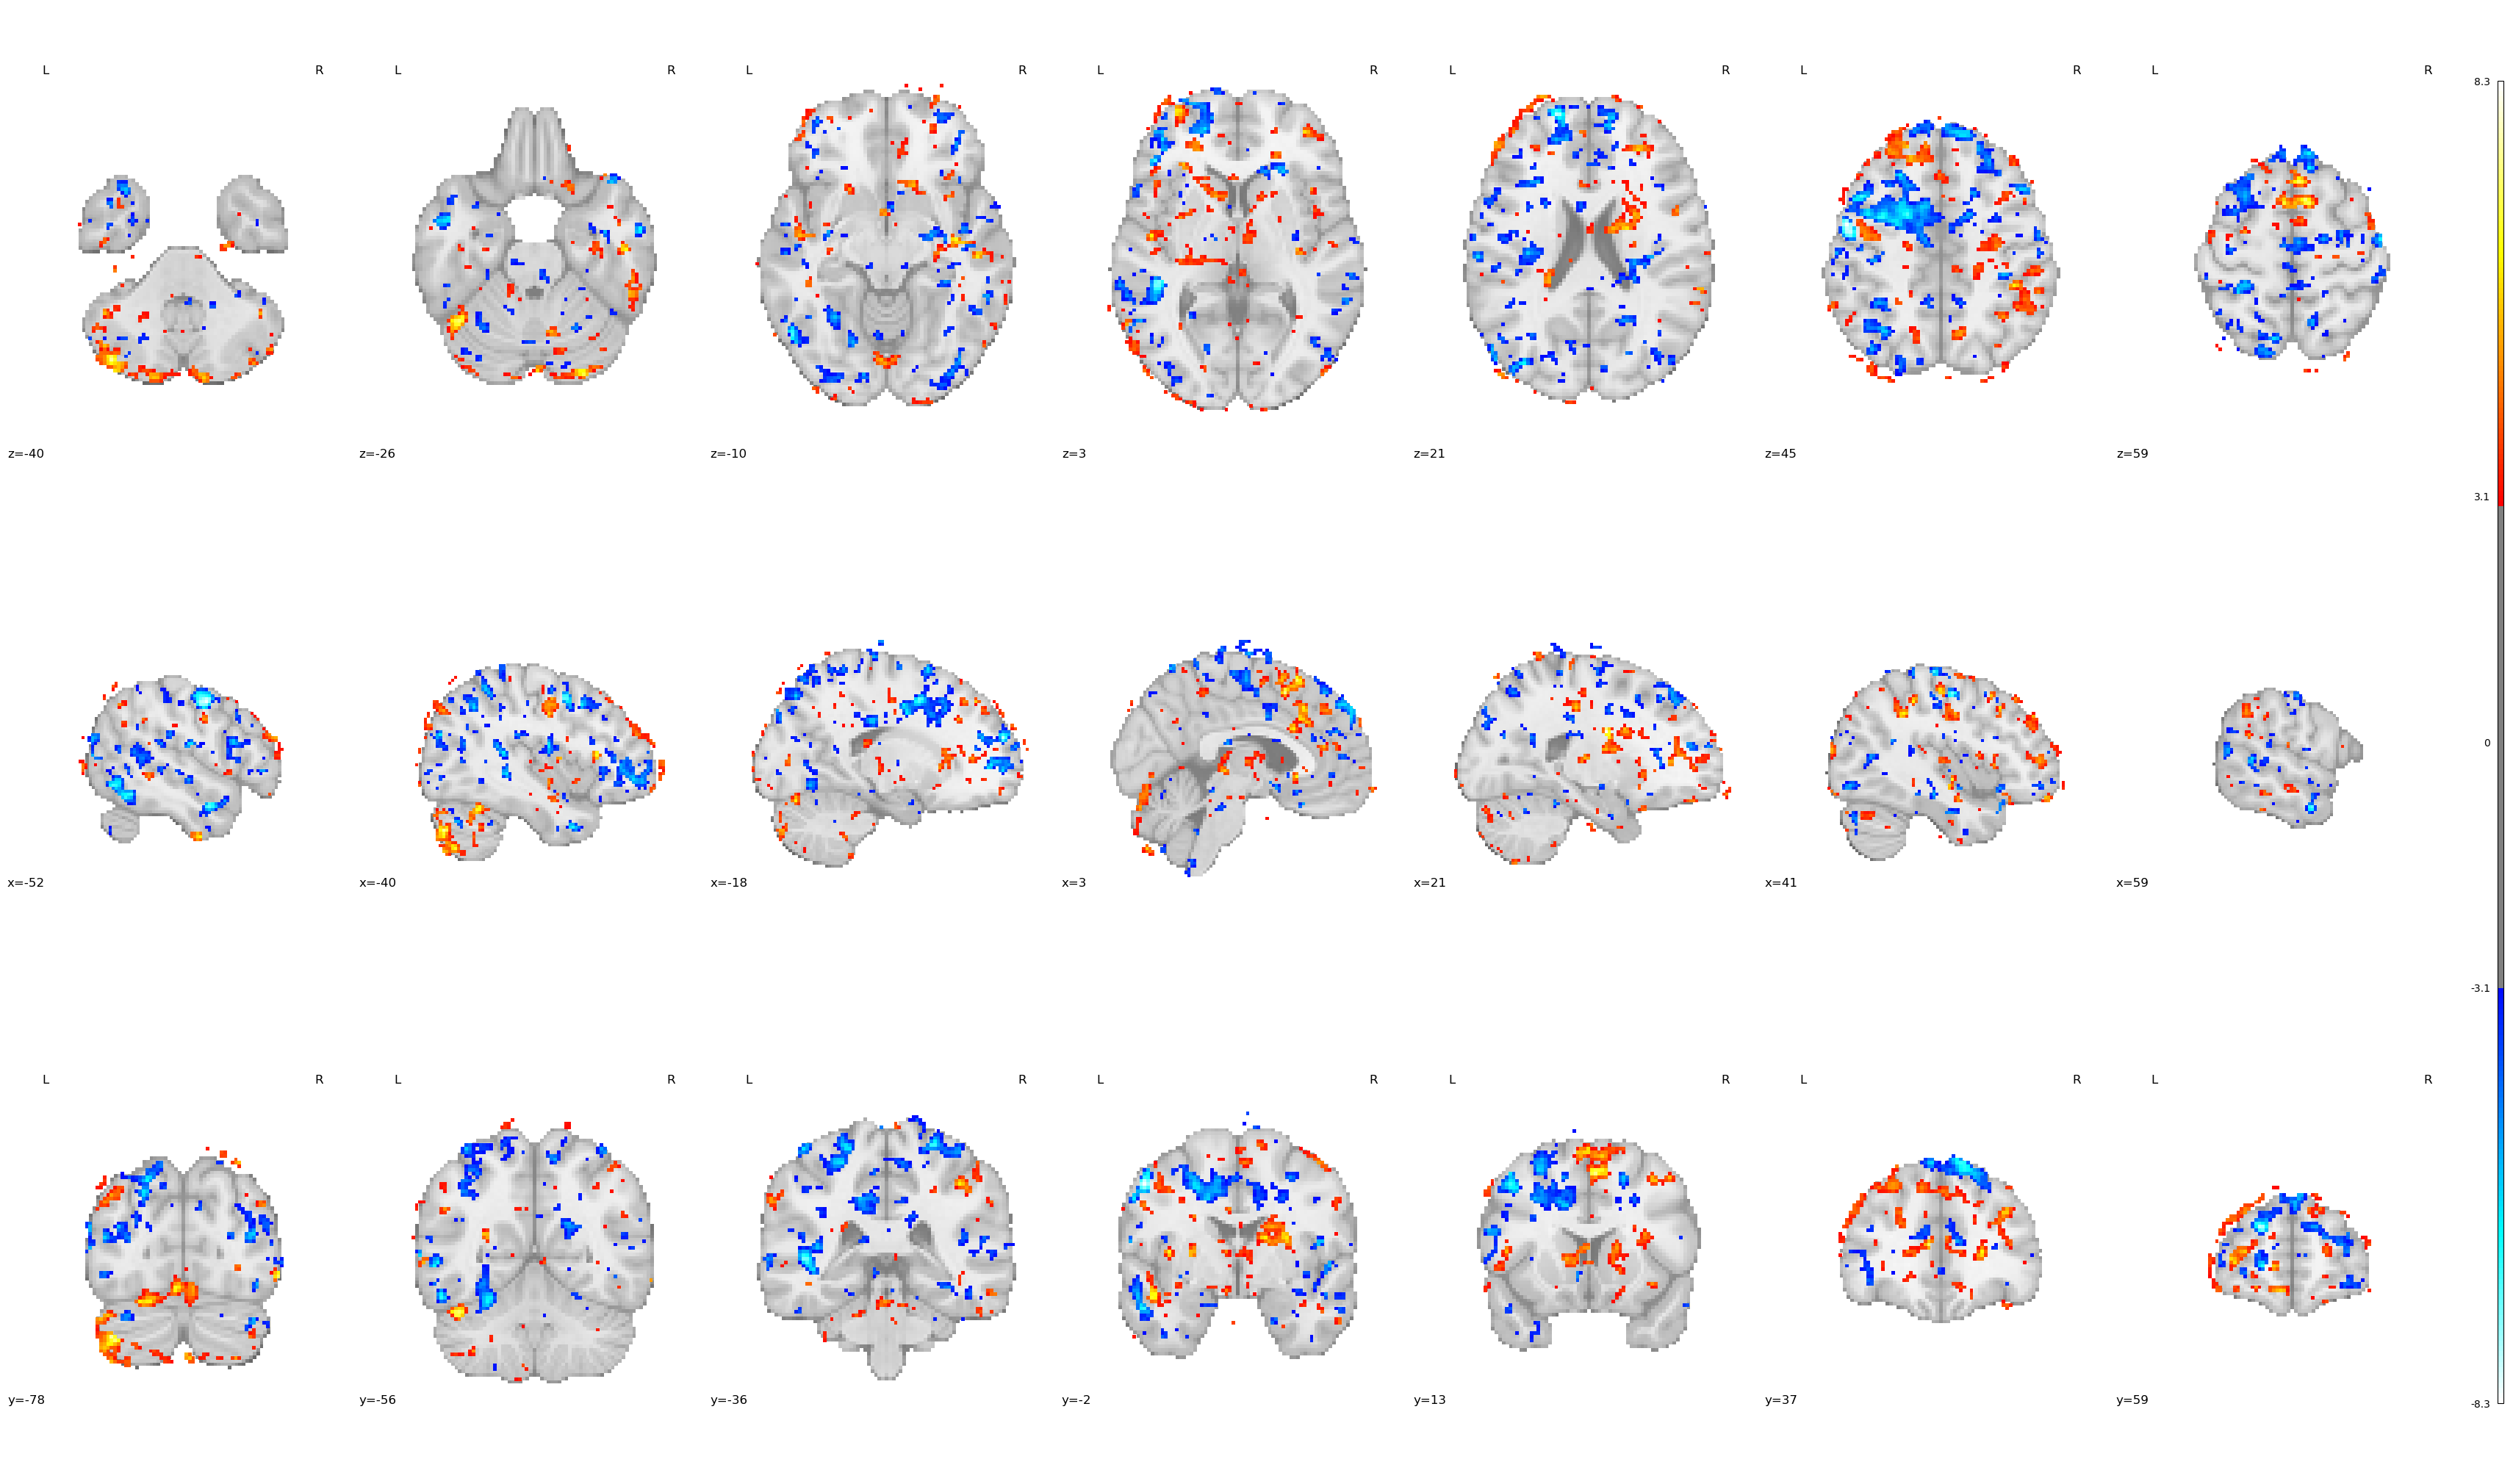

In [276]:
#plotting.plot_stat_map(beta, threshold=3, cut_coords=(5,25,-10))
#plotting.plot_stat_map(beta, threshold=3, cut_coords=(-5,25,-10))
plotting.plot_stat_map(beta, threshold=3.09, display_mode='mosaic')
plt.show()

In [277]:
from scipy.stats import norm

p_val = 0.001
p001_uncorrected = norm.isf(p_val)

from nilearn.glm import cluster_level_inference

proportion_true_discoveries_img = cluster_level_inference(
    beta, mask_img=resampled_mask, threshold=3, alpha=0.05
)


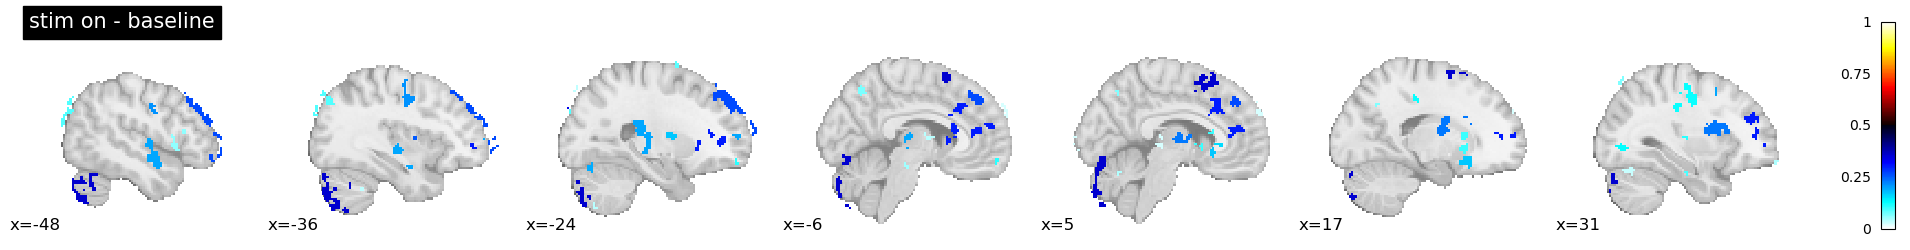

In [278]:
from nilearn import plotting

plotting.plot_stat_map(
    proportion_true_discoveries_img,
    threshold=0.0,
    display_mode="x",
    vmax=1,
    colorbar=True,
    title="stim on - baseline",
)

In [150]:
## GLM ends here

In [151]:
rois = np.unique(np.array(atlas.get_fdata()))
rois

array([   0.,    1.,    2., ...,  998.,  999., 1000.])

In [128]:
mu_pwr_pre = np.zeros(len(rois))
mu_pwr_fus = np.zeros(len(rois))
mu_pwr_post = np.zeros(len(rois))

sigma_pre = np.zeros(len(rois))
sigma_fus = np.zeros(len(rois))
sigma_post = np.zeros(len(rois))

stim_onsets = 300+np.array([0,60,120,180,240])
epoch_len = 60
pre_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )
fus_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )
post_epoch = np.zeros( ( len(stim_onsets), epoch_len, len(rois) ) )

n_voxels_in_roi = np.zeros(len(rois))

idx_pre = np.arange(300)
idx_fus = np.arange(300,600)
idx_post = np.arange(600,900)

for i, roi in enumerate(rois):

    print(i, roi)

    is_in_roi = nilearn.image.get_data(atlas)==roi

    atlased_resampled_bold = resampled_bold.get_fdata()[is_in_roi]

    mu_pwr_pre[i] = np.mean(np.mean(atlased_resampled_bold[:,idx_pre], axis=1))
    mu_pwr_fus[i] = np.mean(np.mean(atlased_resampled_bold[:,idx_fus], axis=1))
    mu_pwr_post[i] = np.mean(np.mean(atlased_resampled_bold[:,idx_post], axis=1))

    sigma_pre[i] = np.mean(np.std(atlased_resampled_bold[:,idx_pre], axis=1))
    sigma_fus[i] = np.mean(np.std(atlased_resampled_bold[:,idx_fus], axis=1))
    sigma_post[i] = np.mean(np.std(atlased_resampled_bold[:,idx_post], axis=1))

    for ii, onset in enumerate(stim_onsets):
        if int(onset)+epoch_len < atlased_resampled_bold.shape[1]:
            pre_epoch[ii,:, i] = np.mean(atlased_resampled_bold[:,int(onset):int(onset)+epoch_len], axis=0)
            fus_epoch[ii,:, i] = np.mean(atlased_resampled_bold[:,int(onset):int(onset)+epoch_len], axis=0)
            post_epoch[ii,:, i] = np.mean(atlased_resampled_bold[:,int(onset):int(onset)+epoch_len], axis=0)
        else:
            # fill with nans
            pre_epoch[ii,:, i] = np.nan
            fus_epoch[ii,:, i] = np.nan
            post_epoch[ii,:, i] = np.nan

    n_voxels_in_roi[i] = np.sum(is_in_roi)

# nanmean across epochs
pre_epoch_mean = np.nanmean(pre_epoch, axis=0)
fus_epoch_mean = np.nanmean(fus_epoch, axis=0)
post_epoch_mean = np.nanmean(post_epoch, axis=0)

0 0.0
1 1.0
2 2.0
3 3.0
4 4.0
5 5.0
6 6.0
7 7.0
8 8.0
9 9.0
10 10.0
11 11.0
12 12.0
13 13.0
14 14.0
15 15.0
16 16.0
17 17.0
18 18.0
19 19.0
20 20.0
21 21.0
22 22.0
23 23.0
24 24.0
25 25.0
26 26.0
27 27.0
28 28.0
29 29.0
30 30.0
31 31.0
32 32.0
33 33.0
34 34.0
35 35.0
36 36.0
37 37.0
38 38.0
39 39.0
40 40.0
41 41.0
42 42.0
43 43.0
44 44.0
45 45.0
46 46.0
47 47.0
48 48.0
49 49.0
50 50.0
51 51.0
52 52.0
53 53.0
54 54.0
55 55.0
56 56.0
57 57.0
58 58.0
59 59.0
60 60.0
61 61.0
62 62.0
63 63.0
64 64.0
65 65.0
66 66.0
67 67.0
68 68.0
69 69.0
70 70.0
71 71.0
72 72.0
73 73.0
74 74.0
75 75.0
76 76.0
77 77.0
78 78.0
79 79.0
80 80.0
81 81.0
82 82.0
83 83.0
84 84.0
85 85.0
86 86.0
87 87.0
88 88.0
89 89.0
90 90.0
91 91.0
92 92.0
93 93.0
94 94.0
95 95.0
96 96.0
97 97.0
98 98.0
99 99.0
100 100.0
101 101.0
102 102.0
103 103.0
104 104.0
105 105.0
106 106.0
107 107.0
108 108.0
109 109.0
110 110.0
111 111.0
112 112.0
113 113.0
114 114.0
115 115.0
116 116.0
117 117.0
118 118.0
119 119.0
120 120.0
121 121.0


In [152]:
# make a dataframe with roi as the index and the mu_pwr_pre, mu_pwr_fus, mu_pwr_post as columns
df = pd.DataFrame(data={'pre':mu_pwr_pre, 'fus':mu_pwr_fus, 'post':mu_pwr_post, 'n_voxels':n_voxels_in_roi}, index=rois)

pct_change_acute = 100*(mu_pwr_fus-mu_pwr_pre)/mu_pwr_pre
pct_change_chronic = 100*(mu_pwr_post-mu_pwr_pre)/mu_pwr_pre

pct_change_std_acute = 100*(sigma_fus-sigma_pre)/sigma_pre
pct_change_std_chronic = 100*(sigma_post-sigma_pre)/sigma_pre

df['pct_change_acute'] = pct_change_acute
df['pct_change_chronic'] = pct_change_chronic
df['pct_change_std_acute'] = pct_change_std_acute
df['pct_change_std_chronic'] = pct_change_std_chronic

(267, 900)

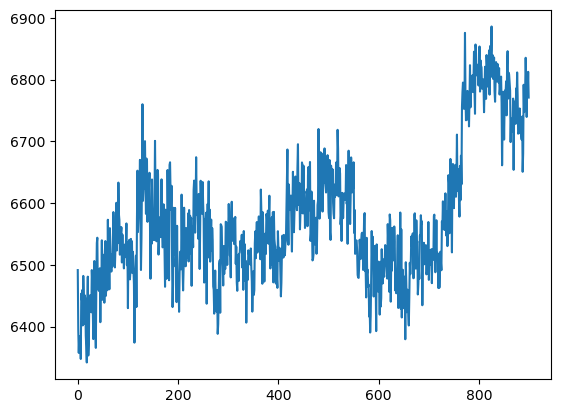

In [153]:
roi=416
is_in_roi = nilearn.image.get_data(atlas)==roi
atlased_resampled_bold = resampled_bold.get_fdata()[is_in_roi]
plt.plot(np.mean(atlased_resampled_bold, axis=0))
atlased_resampled_bold.shape
#plt.plot(atlased_resampled_bold[417,:].T)

In [154]:
df.mean()

pre                       7903.215094
fus                       7883.276914
post                      7900.945219
n_voxels                  1080.954046
pct_change_acute            -0.206160
pct_change_chronic           0.058164
pct_change_std_acute        -1.223847
pct_change_std_chronic      -1.648124
dtype: float64

In [155]:
df

,pre,fus,post,n_voxels,pct_change_acute,pct_change_chronic,pct_change_std_acute,pct_change_std_chronic
0.0,1263.839327,1263.785131,1267.321359,944091.0,-0.004288,0.275512,-0.574096,-0.441092
1.0,8989.034583,8938.539113,9007.632237,219.0,-0.561745,0.206893,-2.768831,-5.455019
2.0,9605.372164,9545.587005,9585.087477,124.0,-0.622414,-0.211181,-1.410925,-1.736963
3.0,8609.786531,8609.020453,8713.641777,201.0,-0.008898,1.206246,-6.044270,-13.284411
4.0,7658.645950,7538.108461,7651.184809,171.0,-1.573875,-0.097421,-5.418352,-11.407980
...,...,...,...,...,...,...,...,...
996.0,8153.418568,8138.551957,8135.842238,152.0,-0.182336,-0.215570,-4.321165,0.140330
997.0,7367.999932,7391.463964,7463.358972,95.0,0.318459,1.294232,-1.945011,-3.416194
998.0,8762.846936,8761.375775,8787.247937,98.0,-0.016789,0.278460,0.393851,-1.739385
999.0,7044.963641,7006.537073,7011.499261,96.0,-0.545447,-0.475011,3.004985,5.597265


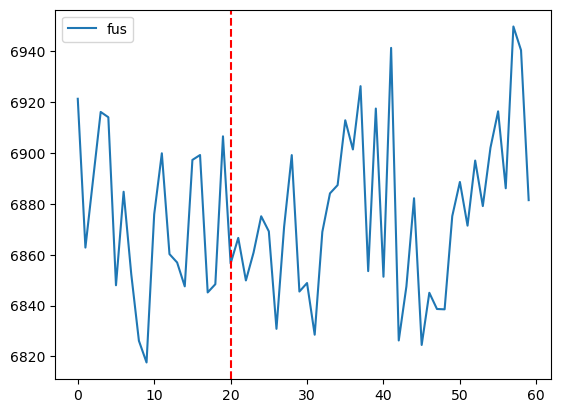

In [156]:
roi=134
# draw a vertical line at t=20
#plt.plot(pre_epoch_mean[:,roi], label='pre')
plt.plot(fus_epoch_mean[:,roi], label='fus')
#plt.plot(np.mean(fus_epoch_mean, axis=1), label='fus mean')
#plt.plot(post_epoch_mean[:,roi], label='post')
plt.axvline(x=20, color='r', linestyle='--')
plt.legend()

In [18]:
'''
mu_roi_ts_pre = np.mean(atlased_resampled_pre_img, axis=0)
mu_roi_ts_fus = np.mean(atlased_resampled_fus_img, axis=0)
mu_roi_ts_post = np.mean(atlased_resampled_post_img, axis=0)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(mu_roi_ts_pre, label='pre')
ax.plot(mu_roi_ts_fus, label='fus')
ax.plot(mu_roi_ts_post, label='post')
plt.legend()
'''

"\nmu_roi_ts_pre = np.mean(atlased_resampled_pre_img, axis=0)\nmu_roi_ts_fus = np.mean(atlased_resampled_fus_img, axis=0)\nmu_roi_ts_post = np.mean(atlased_resampled_post_img, axis=0)\n\nfig, ax = plt.subplots(1,1,figsize=(10,5))\nax.plot(mu_roi_ts_pre, label='pre')\nax.plot(mu_roi_ts_fus, label='fus')\nax.plot(mu_roi_ts_post, label='post')\nplt.legend()\n"

In [134]:
df.loc[df["pct_change_std_acute"].argmin()]

pre                       6247.460996
fus                       6324.825364
post                      6358.585756
n_voxels                   119.000000
pct_change_acute             1.238333
pct_change_chronic           1.778719
pct_change_std_acute       -16.805373
pct_change_std_chronic     -16.579593
Name: 139.0, dtype: float64

In [135]:
df.pct_change_std_chronic.le(0).mean()

0.6593406593406593

In [22]:
"""
roi = 134
is_in_roi = nilearn.image.get_data(atlas)==roi
atlased_resampled_pre_img = resampled_pre_img.get_fdata()[is_in_roi ]
atlased_resampled_fus_img = resampled_fus_img.get_fdata()[is_in_roi ]
atlased_resampled_post_img = resampled_post_img.get_fdata()[is_in_roi ]

# plot voxel average time series before during and after
#plt.plot(np.mean(atlased_resampled_pre_img, axis=0), label='pre')
#plt.plot(np.mean(atlased_resampled_fus_img, axis=0), label='fus')
#plt.plot(np.mean(atlased_resampled_post_img, axis=0), label='post')
#plt.xlim([120, 180])
"""



"\nroi = 134\nis_in_roi = nilearn.image.get_data(atlas)==roi\natlased_resampled_pre_img = resampled_pre_img.get_fdata()[is_in_roi ]\natlased_resampled_fus_img = resampled_fus_img.get_fdata()[is_in_roi ]\natlased_resampled_post_img = resampled_post_img.get_fdata()[is_in_roi ]\n\n# plot voxel average time series before during and after\n#plt.plot(np.mean(atlased_resampled_pre_img, axis=0), label='pre')\n#plt.plot(np.mean(atlased_resampled_fus_img, axis=0), label='fus')\n#plt.plot(np.mean(atlased_resampled_post_img, axis=0), label='post')\n#plt.xlim([120, 180])\n"

In [23]:
from nilearn import plotting

uid = 'MNI152NLin2009cAsym'
nii = nib.load(api.get(uid, resolution=2, desc=None, suffix='T1w'))
atlas_nii = nib.load(api.get(
    uid, resolution=2,
    desc="1000Parcels17Networks",
    atlas="Schaefer2018",
    suffix='dseg'
))

In [24]:
atlas_nii

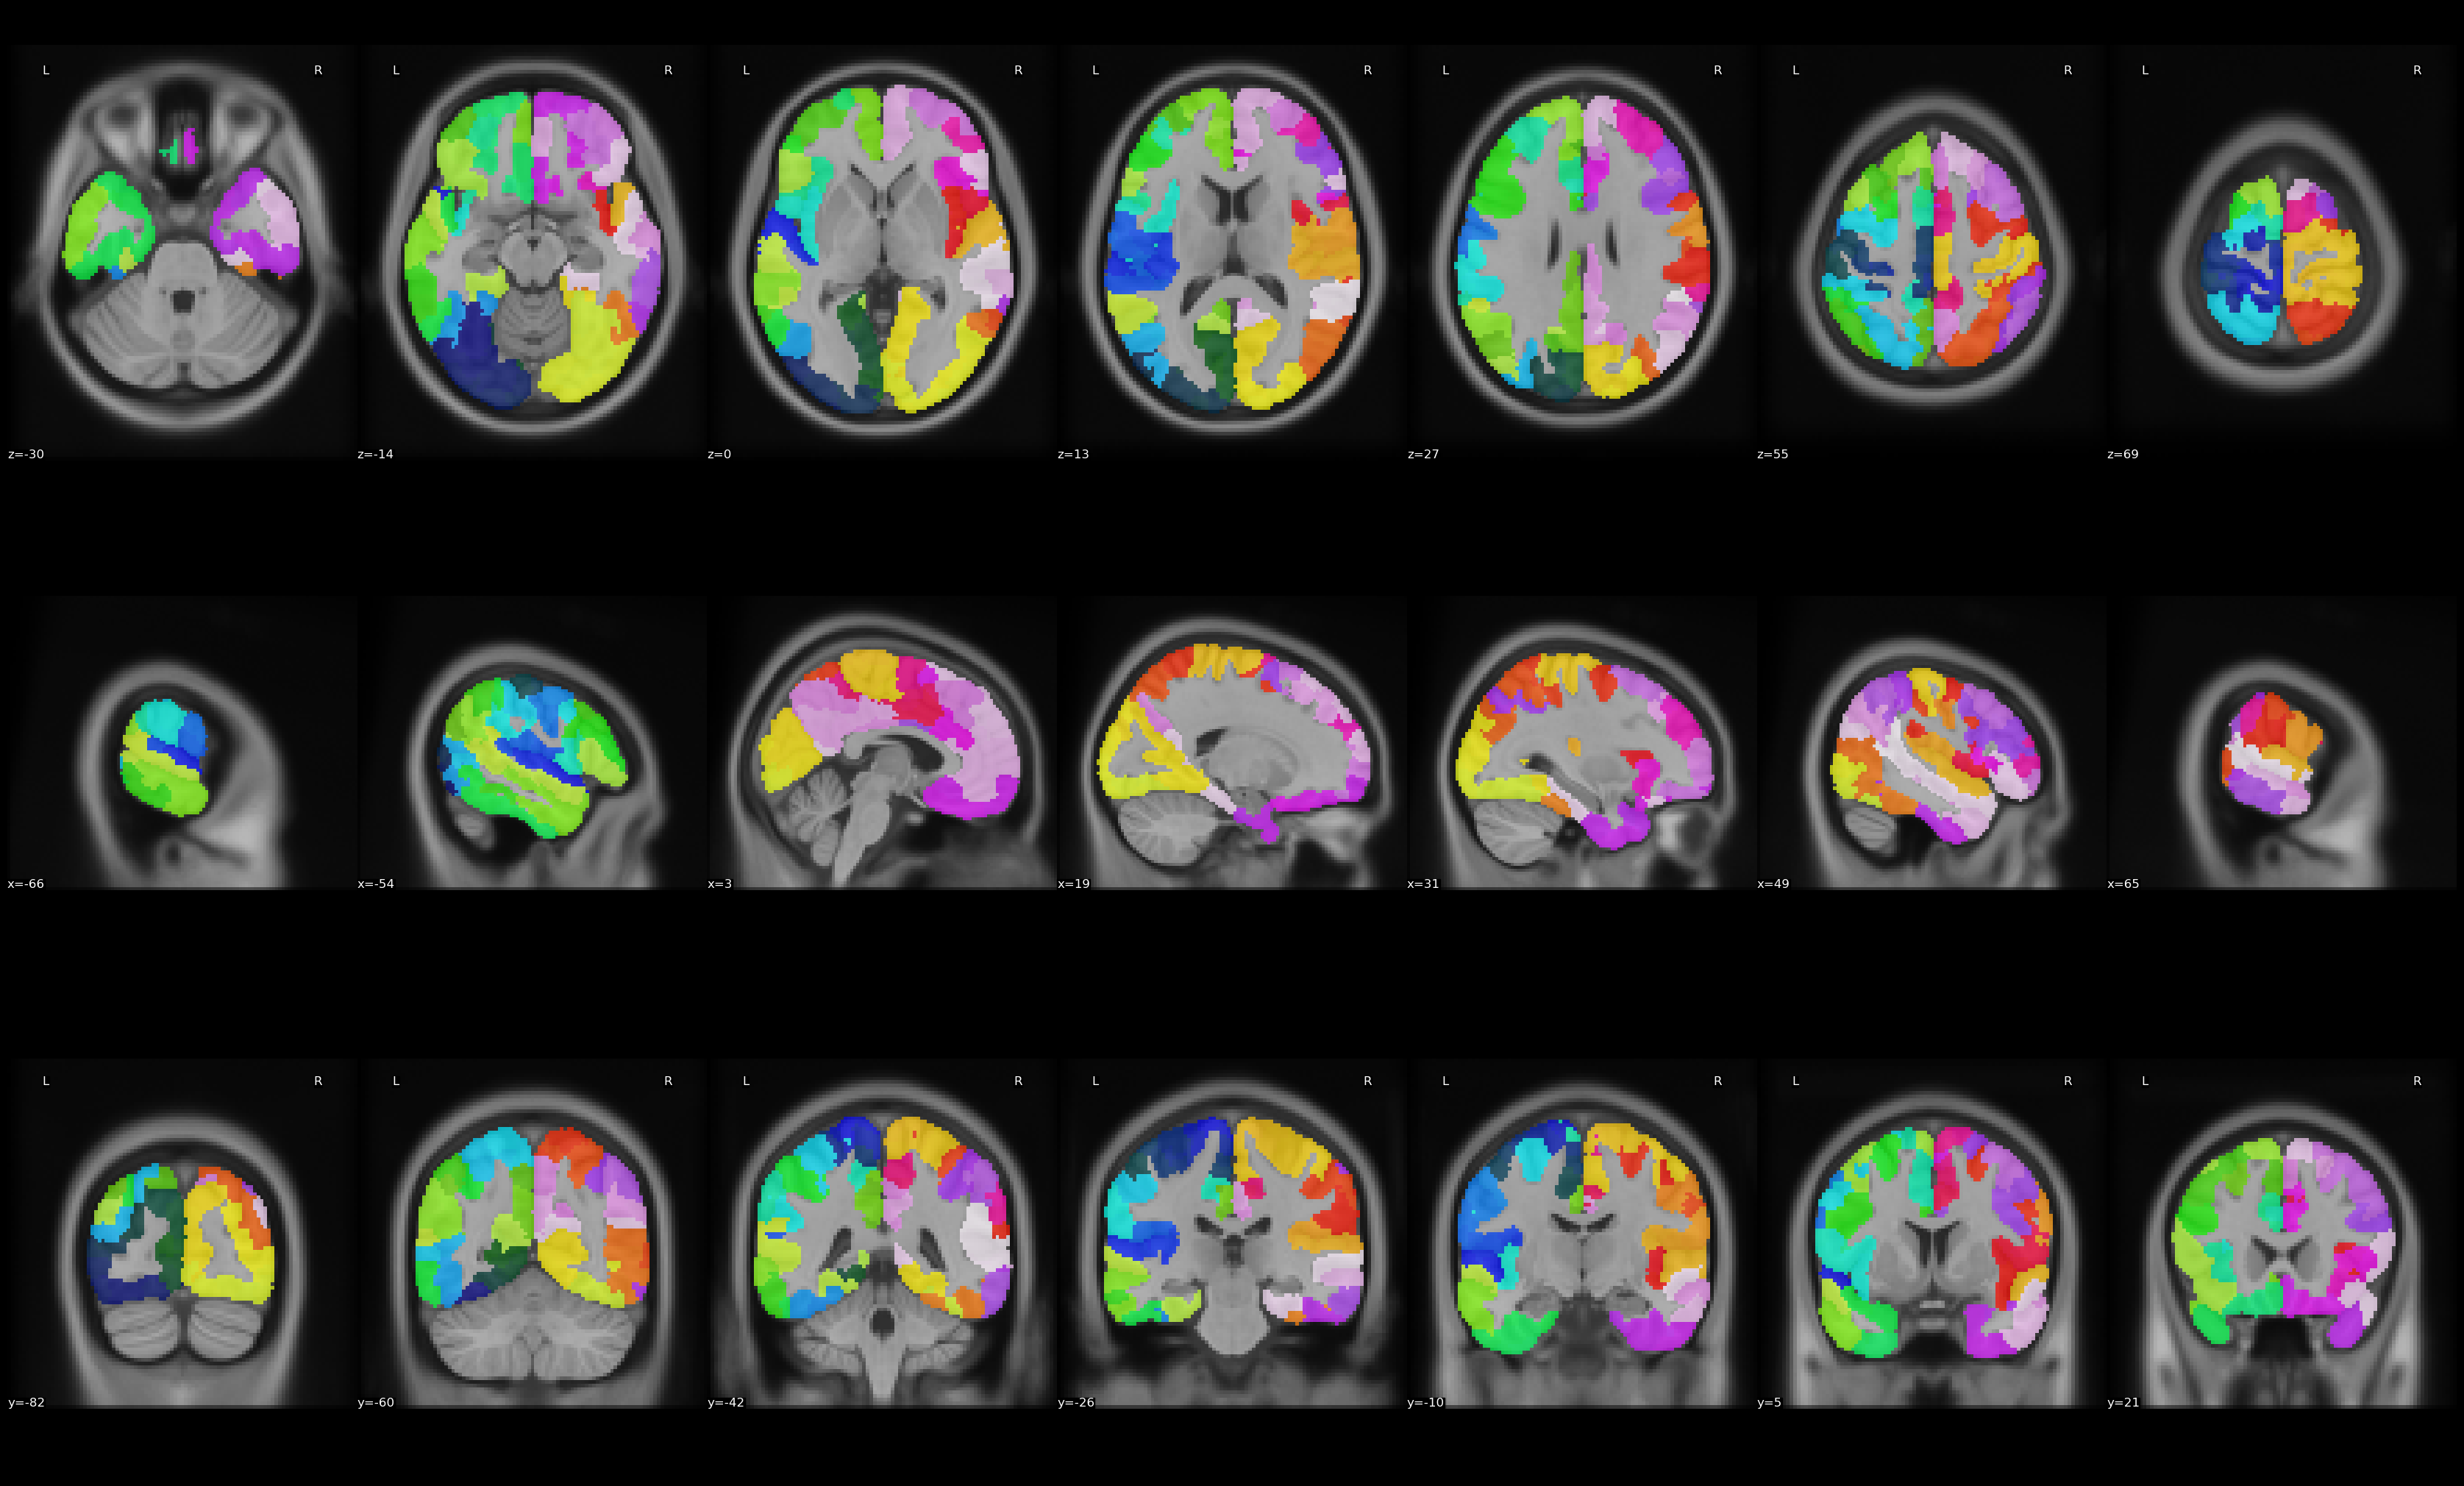

In [25]:
plotting.plot_roi(roi_img=atlas_nii, bg_img=nii, display_mode='mosaic')